### PLS

https://nirpyresearch.com/variable-selection-method-pls-python/

In [1]:
# libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from netCDF4 import Dataset
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import CCA
import matplotlib.ticker as ticker
import math
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from scipy.stats import spearmanr
import openpyxl
#import osgeo
#from osgeo import gdal
#from openpyxl.workbook import Workbook

In [2]:
from sys import stdout
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.signal import savgol_filter

from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import mean_squared_error, r2_score

In [295]:
### PREP DATA ###

## MANUAL INPUT ## -- locate file
sensor = 'PRISMA' #'PRISMA', 'WV3', 'Landsat8', 'terraspec'
target_file = 'C:/Users/htccr/Documents/Aconquija/python_scripts/outputs/' + sensor + '_spots.xlsx'
sensor_meta = pd.read_csv('C:/Users/htccr/Documents/Aconquija/python_scripts/keep/'+ sensor + '_meta.csv', header = 0, index_col = None)
 
data = pd.read_excel(target_file, sheet_name = 'band_mean', header = None, index_col = None) # choose sheet: 'band_mean', 'continuum', 'continuum_removed'
data_std = pd.read_excel(target_file, sheet_name = 'band_std', header = None, index_col = None)
data_vars = pd.read_excel(target_file, sheet_name = 'variables', header = 0, index_col = None)
spots_meta = pd.read_excel('C:/Users/htccr/Documents/Aconquija/python_scripts/outputs/spots_meta.xlsx',sheet_name = 'Sheet1', header = 0, index_col = None)

# decompact data_vars
age = np.array(data_vars['age'])
age_sd = np.array(data_vars['age_sd'])
age_n = np.array(data_vars['age_n'])
fan = np.array(data_vars['fan'])
unit = np.array(data_vars['unit'])
unique = np.array(data_vars['unique'])
pix_count = np.array(data_vars['pix_count'])

# decompact sensor metadata (e.g. nm, band names) and create dictionaries
band_names = sensor_meta.Band
nm_names = sensor_meta.nm.values
nm_names = np.round(nm_names,1)
band_dict_nm = pd.Series(sensor_meta.Name.values,index=nm_names).to_dict()
band_dict_idx  = pd.Series(sensor_meta.Name.values,index=sensor_meta.index.values).to_dict() # create dictionary of band names to wavelength
nm_dict = pd.Series(sensor_meta.nm.values,index=sensor_meta.Band).to_dict() # create dictionary of band names to wavelength

if 'bad_age_idx' in locals():
    del bad_age_idx
if 'bad_band_idx' in locals():
    del bad_band_idx

## MANUAL INPUT ## -- set bands and/or ages to drop
bad_band_idx = np.r_[97:110,141:169,226:230] # choose bands to drop by index
bad_age_idx = np.where((pix_count == 0)| (age == 3.37)) # | (age == 16.48) | (age == 78.5) | (age == 314.48))# | (unit == 'Q2.5a') | (unit == 'Q2.5b')) #  choose age to drop (two decimels)
if 'bad_age_idx' in locals():
    data = data.drop(np.r_[bad_age_idx], axis=0)
    data_std = data_std.drop(np.r_[bad_age_idx], axis=0)
    age = np.delete(age, bad_age_idx)
    age_sd = np.delete(age_sd, bad_age_idx)
    age_n = np.delete(age_n, bad_age_idx)
    fan = np.delete(fan, bad_age_idx)
    unit = np.delete(unit, bad_age_idx)
    unique = np.delete(unique, bad_age_idx)
    pix_count = np.delete(pix_count, bad_age_idx)
    spots_meta = spots_meta.drop(np.r_[bad_age_idx], axis=0)
    
    data_plot = data.copy()
    data_std_plot = data_std.copy()
    print('some ages dropped')
else:
    data_plot = data.copy()
    data_std_plot = data_std.copy()
    print('No ages dropped')
    
# drop chosen values from dataset(s)
if 'bad_band_idx' in locals():
    #data = data.drop(np.r_[bad_band_idx], axis=1)
    #nm_names = np.delete(nm_names, bad_band_idx)
    data.iloc[:,bad_band_idx] = np.nan # if bad bands chosen, set band bands as 0 for PCA` #!!change to 0 if NOT normalizign first!!!
    data_std.iloc[:,bad_band_idx] = np.nan #!!change to 0 if NOT normalizign first!!!
    
    # data for plotting (nan instead of 0 for bad bands)
    data_plot = data.copy()
    data_std_plot = data_std.copy()
    data_plot.iloc[:,bad_band_idx] = np.nan
    data_std_plot.iloc[:,bad_band_idx] = np.nan
    print('some bands dropped')
else:
    # data for plotting (nan instead of 0 for bad bands)
    data_plot = data.copy()
    data_std_plot = data_std.copy()
    print('No bands dropped')

print(np.shape(data))

some ages dropped
some bands dropped
(21, 230)


In [296]:
# normalize each observation to have the same mean & std
data = (data - data.mean())/data.std()
data.iloc[:,bad_band_idx] = 0

X = data
y = age
wl = np.array(nm_names)

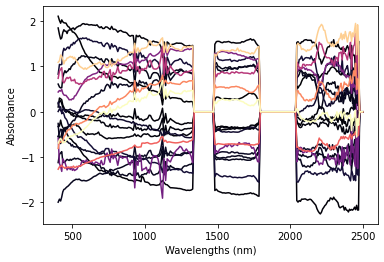

In [297]:
norm = plt.Normalize(vmin=min(age), vmax=max(age))

for i in range(len(y)):
    plt.plot(wl, X.iloc[i],color=plt.cm.magma(norm(age[i])))
    plt.xlabel("Wavelengths (nm)")
    plt.ylabel("Absorbance")

In [150]:
X2 = savgol_filter(X, 17, polyorder=2, deriv=2)

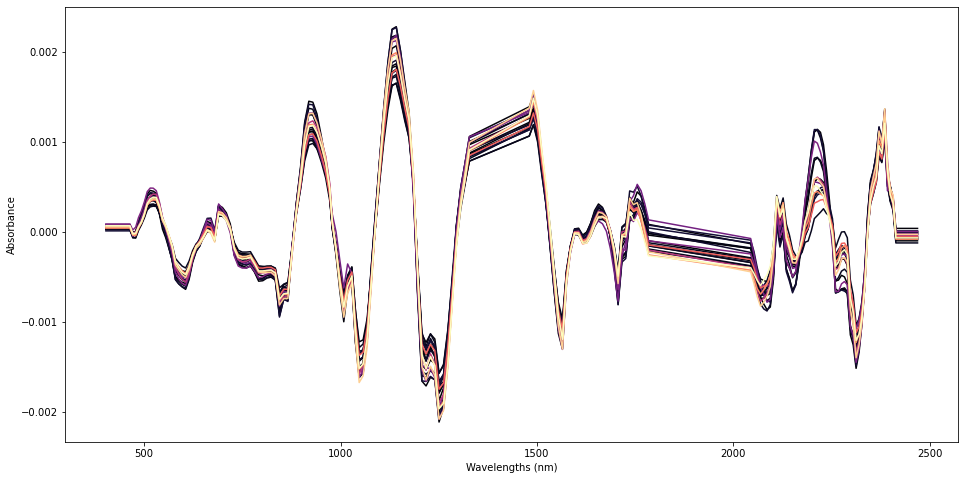

In [151]:
plt.figure(figsize=(16,8))

for i in range(len(y)):
    plt.plot(wl, X2[i],color=plt.cm.magma(norm(age[i])))
    plt.xlabel("Wavelengths (nm)")
    plt.ylabel("Absorbance")

In [152]:
def optimise_pls_cv(X, y, n_comp):
    # Define PLS object
    pls = PLSRegression(n_components=n_comp)

    # Cross-validation
    y_cv = cross_val_predict(pls, X, y, cv=10)

    # Calculate scores
    r2 = r2_score(y, y_cv)
    mse = mean_squared_error(y, y_cv)
    rpd = y.std()/np.sqrt(mse)
    
    return (y_cv, r2, mse, rpd)

In [153]:
# test with 40 components
r2s = []
mses = []
rpds = []
xticks = np.arange(1, 21)
for n_comp in xticks:
    y_cv, r2, mse, rpd = optimise_pls_cv(X, y, n_comp)
    r2s.append(r2)
    mses.append(mse)
    rpds.append(rpd)

C:\Anaconda\envs\geo\lib\site-packages\sklearn\cross_decomposition\_pls.py:305: UserWarning: Y residual is constant at iteration 18
  warnings.warn(f"Y residual is constant at iteration {k}")
C:\Anaconda\envs\geo\lib\site-packages\sklearn\cross_decomposition\_pls.py:305: UserWarning: Y residual is constant at iteration 18
  warnings.warn(f"Y residual is constant at iteration {k}")
C:\Anaconda\envs\geo\lib\site-packages\sklearn\cross_decomposition\_pls.py:305: UserWarning: Y residual is constant at iteration 19
  warnings.warn(f"Y residual is constant at iteration {k}")
C:\Anaconda\envs\geo\lib\site-packages\sklearn\cross_decomposition\_pls.py:305: UserWarning: Y residual is constant at iteration 19
  warnings.warn(f"Y residual is constant at iteration {k}")
C:\Anaconda\envs\geo\lib\site-packages\sklearn\cross_decomposition\_pls.py:305: UserWarning: Y residual is constant at iteration 19
  warnings.warn(f"Y residual is constant at iteration {k}")
C:\Anaconda\envs\geo\lib\site-packages\s

In [298]:
# Plot the mses
def plot_metrics(vals, ylabel, objective):
    with plt.style.context('ggplot'):
        plt.plot(xticks, np.array(vals), '-v', color='blue', mfc='blue')
        if objective=='min':
            idx = np.argmin(vals)
        else:
            idx = np.argmax(vals)
        plt.plot(xticks[idx], np.array(vals)[idx], 'P', ms=10, mfc='red')

        plt.xlabel('Number of PLS components')
        plt.xticks = xticks
        plt.ylabel(ylabel)
        plt.title('PLS')

    plt.show()

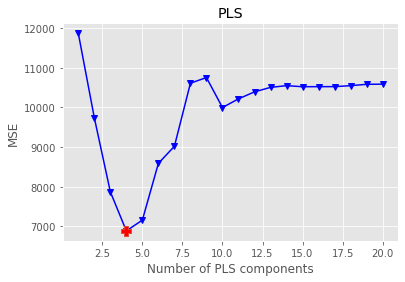

In [299]:
plot_metrics(mses, 'MSE', 'min')


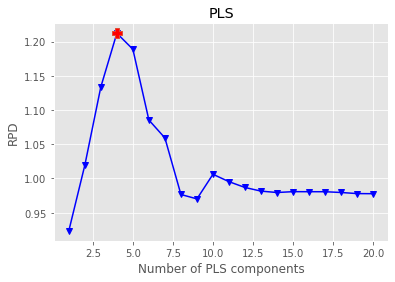

In [300]:
plot_metrics(rpds, 'RPD', 'max')

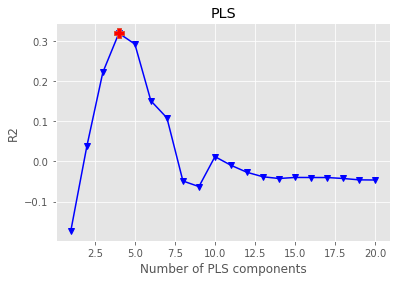

In [301]:
plot_metrics(r2s, 'R2', 'max')

In [302]:
y_cv, r2, mse, rpd = optimise_pls_cv(X, y, 4)

In [303]:
print('R2: %0.4f, MSE: %0.4f, RPD: %0.4f' %(r2, mse, rpd))


R2: 0.3193, MSE: 6886.6286, RPD: 1.2121


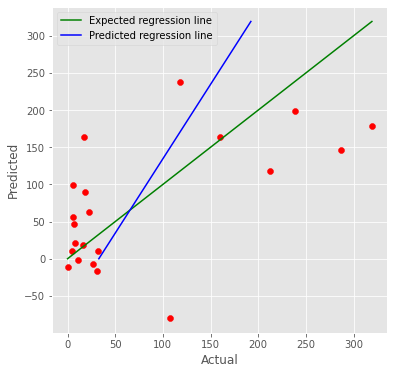

In [304]:
plt.figure(figsize=(6, 6))
with plt.style.context('ggplot'):
    plt.scatter(y, y_cv, color='red')
    plt.plot(y, y, '-g', label='Expected regression line')
    z = np.polyfit(y, y_cv, 1)
    plt.plot(np.polyval(z, y), y, color='blue', label='Predicted regression line')
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.legend()
    plt.plot()

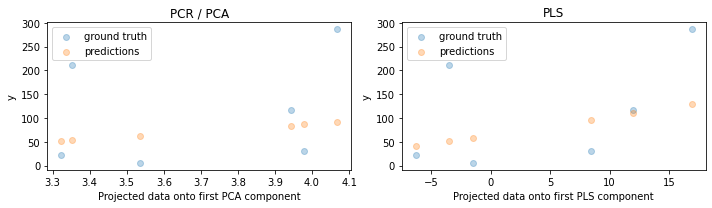

In [266]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression

X_train, X_test, y_train, y_test = train_test_split(X, y)

pcr = make_pipeline(StandardScaler(), PCA(n_components=1), LinearRegression())
pcr.fit(X_train, y_train)
pca = pcr.named_steps["pca"]  # retrieve the PCA step of the pipeline

pls = PLSRegression(n_components=1)
pls.fit(X_train, y_train)

fig, axes = plt.subplots(1, 2, figsize=(10, 3))
axes[0].scatter(pca.transform(X_test), y_test, alpha=0.3, label="ground truth")
axes[0].scatter(
    pca.transform(X_test), pcr.predict(X_test), alpha=0.3, label="predictions"
)
axes[0].set(
    xlabel="Projected data onto first PCA component", ylabel="y", title="PCR / PCA"
)
axes[0].legend()
axes[1].scatter(pls.transform(X_test), y_test, alpha=0.3, label="ground truth")
axes[1].scatter(
    pls.transform(X_test), pls.predict(X_test), alpha=0.3, label="predictions"
)
axes[1].set(xlabel="Projected data onto first PLS component", ylabel="y", title="PLS")
axes[1].legend()
plt.tight_layout()
plt.show()

In [305]:
from sys import stdout
 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
 
from scipy.signal import savgol_filter
 
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import mean_squared_error, r2_score



In [306]:
#X = savgol_filter(X, 11, polyorder = 2, deriv=1)
#X = savgol_filter(X, 13, polyorder = 2,deriv=2)
X = np.array(X)

In [256]:
X[:,bad_band_idx] = 0 # if bad bands chosen, set band bands as 0 for PCA` #!!change to 0 if NOT normalizign first!!!

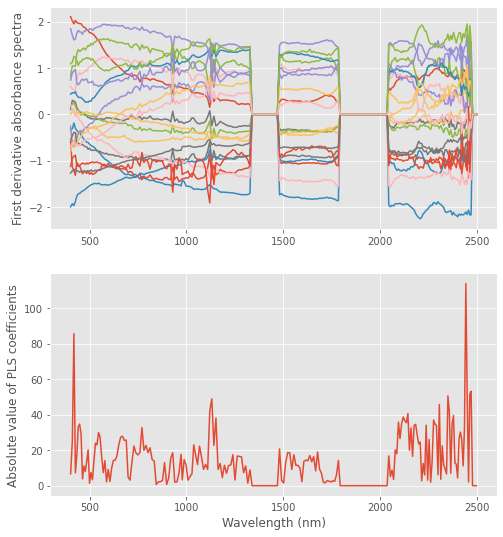

In [307]:
# Define the PLS regression object
pls = PLSRegression(n_components=8)
# Fit data
pls.fit(X, y)
 
# Plot spectra
plt.figure(figsize=(8,9))

with plt.style.context(('ggplot')):
    ax1 = plt.subplot(211)
    plt.plot(wl, X.T)
    plt.ylabel('First derivative absorbance spectra')

    ax2 = plt.subplot(212, sharex=ax1)
    plt.plot(wl, np.abs(pls.coef_[:,0]))
    plt.xlabel('Wavelength (nm)')
    plt.ylabel('Absolute value of PLS coefficients')

    plt.show()

In [308]:
# Get the list of indices that sorts the PLS coefficients in ascending order 
# of the absolute value
sorted_ind = np.argsort(np.abs(pls.coef_[:,0]))
 
# Sort spectra according to ascending absolute value of PLS coefficients
Xc = X[:,sorted_ind]

In [309]:

def pls_variable_selection(X, y, max_comp):
    
    # Define MSE array to be populated
    mse = np.zeros((max_comp,X.shape[1]))
 
    # Loop over the number of PLS components
    for i in range(max_comp):
        
        # Regression with specified number of components, using full spectrum
        pls1 = PLSRegression(n_components=i+1)
        pls1.fit(X, y)
        
        # Indices of sort spectra according to ascending absolute value of PLS coefficients
        sorted_ind = np.argsort(np.abs(pls1.coef_[:,0]))
 
        # Sort spectra accordingly 
        Xc = X[:,sorted_ind]
 
        # Discard one wavelength at a time of the sorted spectra,
        # regress, and calculate the MSE cross-validation
        for j in range(Xc.shape[1]-(i+1)):
 
            pls2 = PLSRegression(n_components=i+1)
            pls2.fit(Xc[:, j:], y)
            
            y_cv = cross_val_predict(pls2, Xc[:, j:], y, cv=5)
 
            mse[i,j] = mean_squared_error(y, y_cv)
    
        comp = 100*(i+1)/(max_comp)
        stdout.write("\r%d%% completed" % comp)
        stdout.flush()
    stdout.write("\n")
 
    # # Calculate and print the position of minimum in MSE
    mseminx,mseminy = np.where(mse==np.min(mse[np.nonzero(mse)]))
 
    print("Optimised number of PLS components: ", mseminx[0]+1)
    print("Wavelengths to be discarded ",mseminy[0])
    print('Optimised MSEP ', mse[mseminx,mseminy][0])
    stdout.write("\n")
    # plt.imshow(mse, interpolation=None)
    # plt.show()
 
 
    # Calculate PLS with optimal components and export values
    pls = PLSRegression(n_components=mseminx[0]+1)
    pls.fit(X, y)
        
    sorted_ind = np.argsort(np.abs(pls.coef_[:,0]))
 
    Xc = X[:,sorted_ind]
 
    return(Xc[:,mseminy[0]:],mseminx[0]+1,mseminy[0], sorted_ind)

In [320]:

def simple_pls_cv(X, y, n_comp):
 
    # Run PLS with suggested number of components
    pls = PLSRegression(n_components=n_comp)
    pls.fit(X, y)
    y_c = pls.predict(X)
 
    # Cross-validation
    y_cv = cross_val_predict(pls, X, y, cv=10)    
 
    # Calculate scores for calibration and cross-validation
    score_c = r2_score(y, y_c)
    score_cv = r2_score(y, y_cv)
 
    # Calculate mean square error for calibration and cross validation
    mse_c = mean_squared_error(y, y_c)
    mse_cv = mean_squared_error(y, y_cv)
 
    print('R2 calib: %5.3f'  % score_c)
    print('R2 CV: %5.3f'  % score_cv)
    print('MSE calib: %5.3f' % mse_c)
    print('MSE CV: %5.3f' % mse_cv)
 
    # Plot regression 
 
    z = np.polyfit(y, y_cv, 1)
    with plt.style.context(('ggplot')):
        fig, ax = plt.subplots(figsize=(9, 5))
        ax.scatter(y, y_cv, c='red', edgecolors='k')
        ax.plot(z[1]+z[0]*y, y, c='blue', linewidth=1)
        ax.plot(y, y, color='green', linewidth=1)
        plt.title('$R^{2}$ (CV): '+str(score_cv))
        plt.ylabel('Predicted Age')
        plt.xlabel('Measured Age')
        
        plt.show()

R2 calib: 0.921
R2 CV: 0.081
MSE calib: 803.026
MSE CV: 9295.018


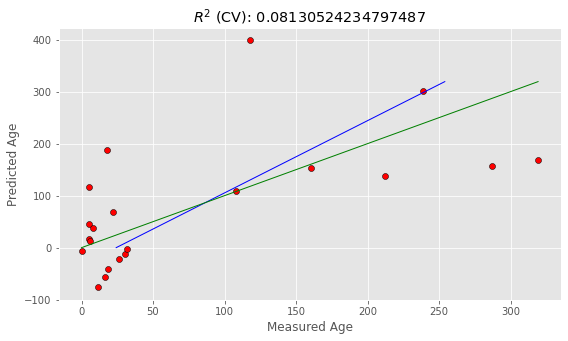

In [321]:
simple_pls_cv(X, y, 8)

100% completed
Optimised number of PLS components:  12
Wavelengths to be discarded  173
Optimised MSEP  4216.995413641553

R2 calib: 1.000
R2 CV: 0.700
MSE calib: 4.820
MSE CV: 3038.701


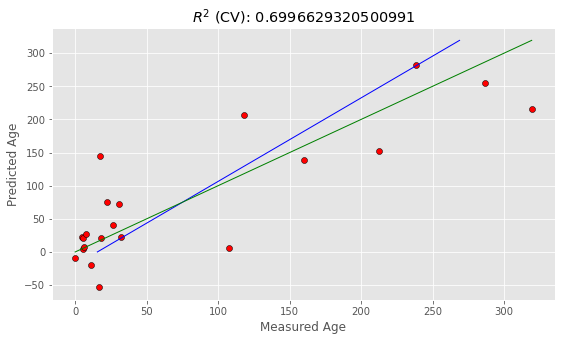

In [322]:
opt_Xc, ncomp, wav, sorted_ind = pls_variable_selection(X, y, 15)
simple_pls_cv(opt_Xc, y, ncomp)

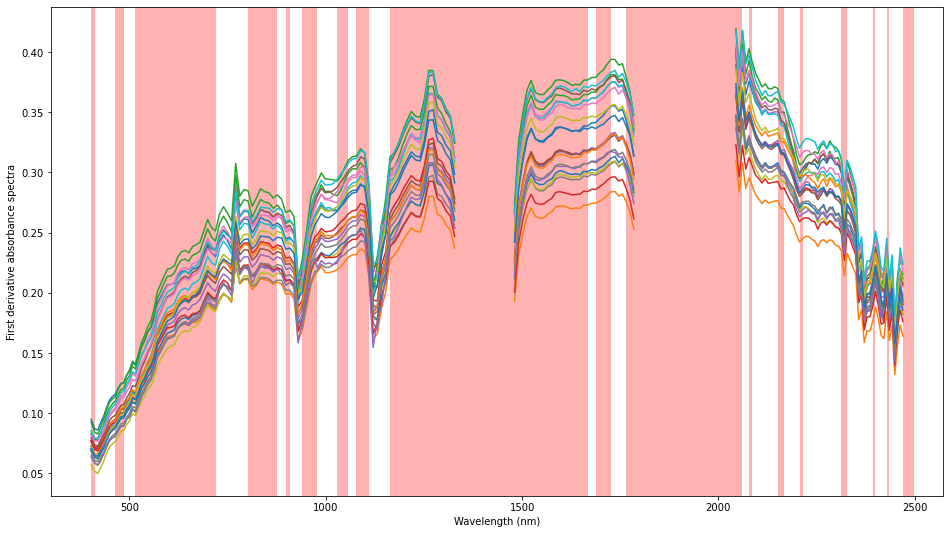

In [323]:


# Get a boolean array according to the indices that are being discarded
ix = np.in1d(wl.ravel(), wl[sorted_ind][:wav])
 
import matplotlib.collections as collections
 
# Plot spectra with superimpose selected bands
fig, ax = plt.subplots(figsize=(16,9))
with plt.style.context(('ggplot')):
    ax.plot(wl, np.array(data_plot.T))
    plt.ylabel('First derivative absorbance spectra')
    plt.xlabel('Wavelength (nm)')
 
collection = collections.BrokenBarHCollection.span_where(
    wl, ymin=-1, ymax=1, where=ix == True, facecolor='red', alpha=0.3)
ax.add_collection(collection)
 
plt.show()